# Лабораторная работа №2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

np.random.seed(1)

In [2]:
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

## Обработка данных

In [3]:
data = pd.read_csv('pulsar_data_train.csv')

In [4]:
data = data.rename(columns={" Mean of the integrated profile": "Mean IP",
                            " Standard deviation of the integrated profile": "Std IP",
                            " Excess kurtosis of the integrated profile": "Kurtosis IP",
                            " Skewness of the integrated profile": "Skewness IP",
                            " Mean of the DM-SNR curve": "Mean DM-SNR",
                            " Standard deviation of the DM-SNR curve": "Std DM-SNR",
                            " Excess kurtosis of the DM-SNR curve": "Kurtosis DM-SNR",
                            " Skewness of the DM-SNR curve": "Skewness DM-SNR",
                            "target_class": "class"})
data['class'] = data['class'].astype('int32')

In [5]:
pulsar_means = dict()
non_pulsar_means = dict()
for column in ['Kurtosis IP', 'Std DM-SNR', 'Skewness DM-SNR']:
    pulsar_means[column] = data[data['class'] == 1][column].mean()
    non_pulsar_means[column] = data[data['class'] == 0][column].mean()
    
data[data['class'] == 1] = data[data['class'] == 1].fillna(pulsar_means)
data[data['class'] == 0] = data[data['class'] == 0].fillna(non_pulsar_means)

In [6]:
sample = data[data['class'] == 1]
while data[data['class'] == 1].shape[0] + sample.shape[0] < data[data['class'] == 0].shape[0]:
    data = pd.concat([data, sample])
data = pd.concat([data, sample.iloc[:data[data['class'] == 0].shape[0] - data[data['class'] == 1].shape[0]]])

In [7]:
x = data.drop(columns = 'class').to_numpy()
y = data['class'].to_numpy()
train_data, test_data, train_labels, test_labels = train_test_split(x, y, train_size=0.8, random_state=1)

In [8]:
SAVE_FIGS = False

def scores(model, data, labels, name=None):
    pred = model.predict(data)
    print('Accuracy:', accuracy_score(labels, pred))
    print('Precision:', precision_score(labels, pred))
    print('Recall:', recall_score(labels, pred))
    figure = plt.figure(figsize=(12, 4))
    matrix = confusion_matrix(labels, pred)
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(matrix).plot(ax=ax)
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(labels, pred, ax=ax)
    plt.subplots_adjust(wspace=0.3)
    if SAVE_FIGS and name is not None:
        plt.savefig(name, format='pdf')
    plt.show()

## Дерево решений

In [9]:
def entropy(x, from_proba=False):
    if from_proba:
        return np.sum(-x * np.log2(x + (np.abs(x) < 1e-12)))
    else:
        _, counts = np.unique(x, return_counts=True)
        p = counts / len(x)
        return np.sum(-p * np.log2(p))

def gini(x, from_proba=False):
    if from_proba:
        return np.sum(x * (1 - x))
    else:
        _, counts = np.unique(x, return_counts=True)
        p = counts / len(x)
        return np.sum(p * (1 - p))

class DecisionTree(BaseEstimator, ClassifierMixin):
    class Node:
        def __init__(self):
            self.feature = -1
            self.value = None
            self.left = None
            self.right = None
            self.size = 0
    
    def __init__(self, min_leaf_size=5, max_depth=None, criterion=entropy, features=None):
        self.min_leaf_size = min_leaf_size
        self.max_depth = max_depth
        self.criterion = criterion
        self.features = features
    
    def fit(self, data, labels):
        self.root = self.Node()
        self.classes = len(np.unique(labels))
        self.process_node(data, labels, self.root, np.arange(len(labels)), 0)
        return self
        
    def process_node(self, data, labels, node, ids, depth):
        X = data[ids]
        Y = labels[ids]
        n = len(X)
        values, c = np.unique(Y, return_counts=True)
        counts = np.zeros((self.classes, ))
        counts[values] += c
        node.size = n
        
        if (self.max_depth is not None) and depth == self.max_depth or \
           (self.min_leaf_size is not None) and n <= self.min_leaf_size or \
           len(values) == 1:
            node.value = counts / n
            return
        
        h = self.criterion(Y)
        max_value = None
        max_f = None
        max_gain = -1
        best_left_ids = None
        best_right_ids = None
        for f in (self.features if self.features is not None else range(data.shape[1])):
            sort_ids = X[:, f].argsort()
            left = 1
            left_counts = np.zeros(2)
            left_counts[Y[sort_ids[0]]] = 1

            while left < n:
                while left < n and X[sort_ids[left-1]][f] == X[sort_ids[left-2]][f]:
                    left += 1
                    left_counts[Y[sort_ids[left-1]]] += 1
                if left == n:
                    break
                    
                p = left_counts / left
                left_h = self.criterion(p, from_proba=True)
                p = (counts - left_counts) / (n - left)
                right_h = self.criterion(p, from_proba=True)

                gain = h - (left * left_h + (n - left) * right_h) / n
                if gain > max_gain:
                    max_gain = gain
                    max_value = X[sort_ids[left-1]][f]
                    max_f = f
                    best_left_ids = sort_ids[:left]
                    best_right_ids = sort_ids[left:]

                left += 1
                left_counts[Y[sort_ids[left-1]]] += 1
        
        if max_value is None:
            node.value = counts / n
            return
        
        node.feature = max_f
        node.value = max_value
        node.left = self.Node()
        node.right = self.Node()
        
        self.process_node(X, Y, node.left, best_left_ids, depth+1)
        self.process_node(X, Y, node.right, best_right_ids, depth+1)
        
    def predict_proba(self, data):
        res = np.ndarray((data.shape[0], self.classes))
        for i, obj in enumerate(data):
            node = self.root
            while node.feature != -1:
                if obj[node.feature] > node.value:
                    node = node.right
                else:
                    node = node.left
            res[i] = node.value
        return res
    
    def predict(self, data):
        return np.argmax(self.predict_proba(data), axis=1)

In [42]:
dt_cv = GridSearchCV(DecisionTree(), 
                     {'criterion': [entropy, gini], 'max_depth': [10, 20, None], 'min_leaf_size': [5, 50]})
dt_cv.fit(train_data, train_labels)
print(dt_cv.best_params_, dt_cv.best_score_, sep='\n')

{'criterion': <function gini at 0x0000010EA9BB2EF0>, 'max_depth': 20, 'min_leaf_size': 5}
0.9880769230769232


Accuracy: 0.9892307692307692
Precision: 0.9792117799913382
Recall: 0.9995579133510168


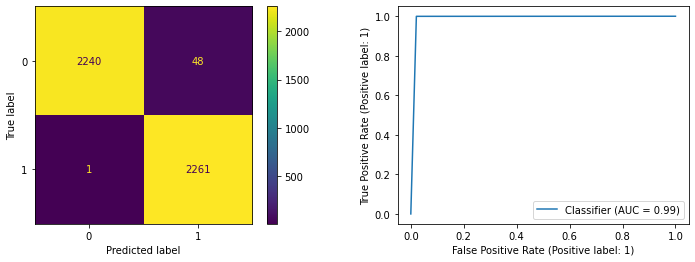

In [43]:
dt = dt_cv.best_estimator_
scores(dt, test_data, test_labels, 'tree.pdf')

In [22]:
skdt_cv = GridSearchCV(DecisionTreeClassifier(), 
                       {'criterion': ['entropy', 'gini'], 
                        'max_depth': [5, 10, 20, None], 
                        'min_samples_leaf': [5, 50, 100],
                        'splitter' : ['best', 'random']})
skdt_cv.fit(train_data, train_labels)
print(skdt_cv.best_params_, skdt_cv.best_score_, sep='\n')

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'splitter': 'best'}
0.984945054945055


Accuracy: 0.9868131868131869
Precision: 0.9766233766233766
Recall: 0.9973474801061007


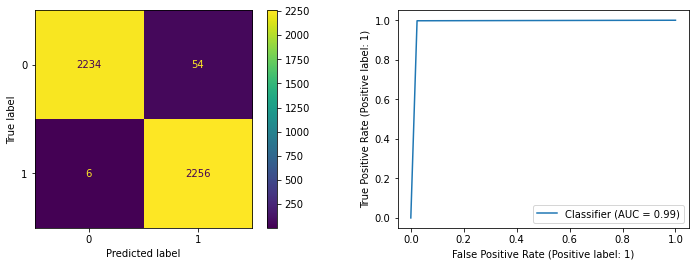

In [23]:
skdt = skdt_cv.best_estimator_
scores(skdt, test_data, test_labels, 'sk_tree.pdf')

In [11]:
def print_tree(node, d = 0):
    if node is None:
        return
    print(' '*4*d, node.feature, node.value)
    print_tree(node.left, d+1)
    print_tree(node.right, d+1)
    
def pair_predict(node, i, j, x, y):
    if node.feature == -1:
        return node.value[0]
    if node.feature == i:
        if node.value > x:
            return pair_predict(node.right, i, j, x, y)
        return pair_predict(node.left, i, j, x, y)
    elif node.feature == j:
        if node.value > y:
            return pair_predict(node.right, i, j, x, y)
        return pair_predict(node.left, i, j, x, y)
    else:
        return (node.left.size * pair_predict(node.left, i, j, x, y) + 
            node.right.size * pair_predict(node.right, i, j, x, y)) / node.size
    
def plot_boundaries(dt, data, labels, name=None, features=None):
    if features is None:
        features = np.arange(data.shape[1])
    colors = [('blue', 'orange')[i] for i in labels]
    plt.figure(figsize=(18, 18))
    for f1 in features:
        for f2 in features:
            if f1 == f2: continue
            xmax, xmin = np.max(data[:, f1]), np.min(data[:, f1])
            ymax, ymin = np.max(data[:, f2]), np.min(data[:, f2])

            n = 100
            x = np.linspace(xmin, xmax, n)
            y = np.linspace(ymin, ymax, n)

            xv, yv = np.meshgrid(x, y)

            z = np.zeros_like(xv)

            for i in range(n):
                for j in range(n):
                    z[i, j] = pair_predict(dt.root, f1, f2, xv[i, j], yv[i, j])

            ax = plt.subplot(len(features), len(features), f2*len(features) + f1 + 1)
            if f2 == 0 or (f2 == 1 and f1 == 0):
                ax.xaxis.tick_top()
            else:
                ax.xaxis.set_visible(False)
                
            if f1 != 0 and not (f1 == 1 and f2 == 0):
                ax.yaxis.set_visible(False)

            plt.scatter(data[:, f1], data[:, f2], c=colors, s=2)
            plt.contourf(xv, yv, z, alpha=0.5)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    if SAVE_FIGS and name is not None:
        plt.savefig(name, format='pdf')
    plt.show()

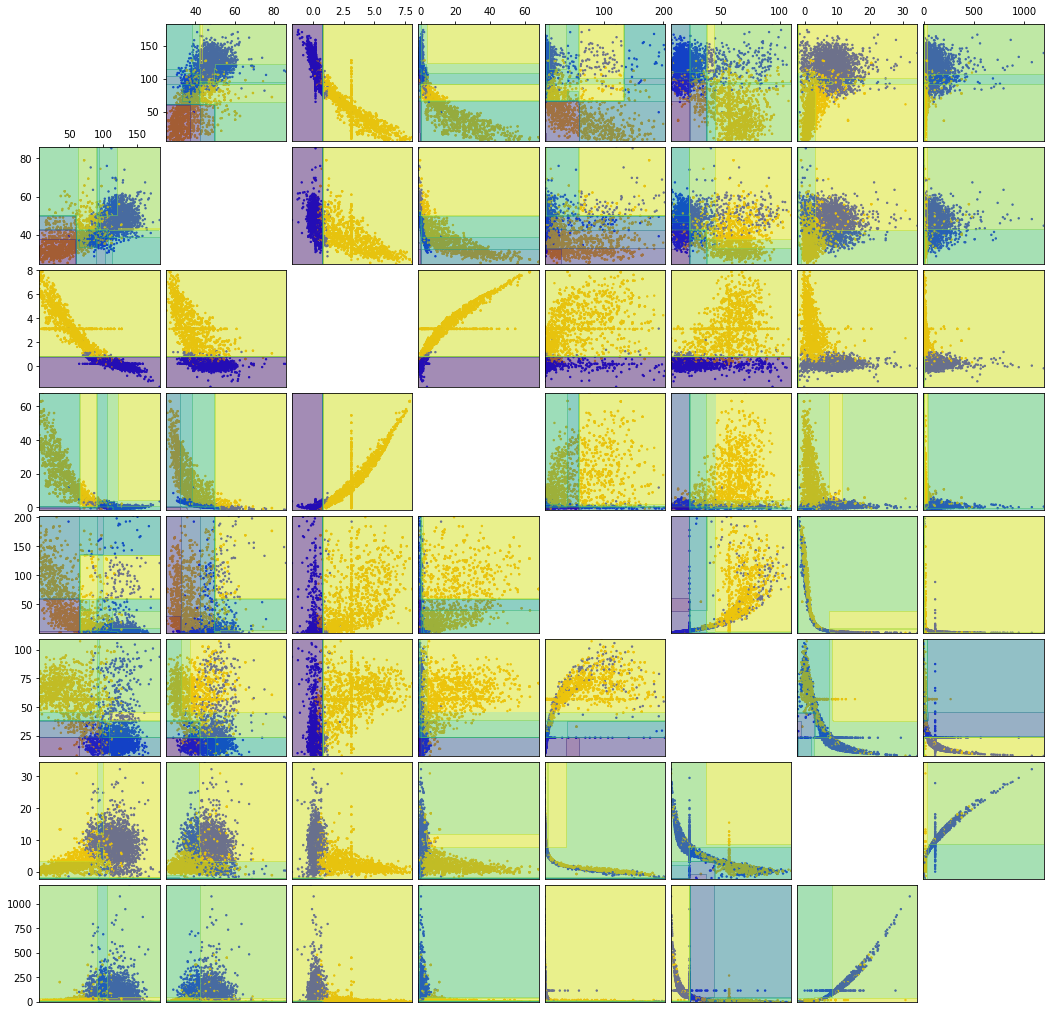

In [14]:
plot_boundaries(dt, test_data, test_labels, 'tree_boundaries.pdf')

## Голосование

In [15]:
def softmax(x):
    expx = np.exp(x)
    X = expx.sum()
    return expx / X

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [16]:
class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=5):
        self.k = k
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        self.classes = len(np.unique(labels))
        return self
    
    def predict(self, data):
        res = np.ndarray((data.shape[0],), dtype=np.int64)
        for i, x in enumerate(data):
            neighbors = np.argpartition(((self.data - data[i]) ** 2).sum(axis=1), self.k - 1)[:self.k]
            values, counts = np.unique(self.labels[neighbors], return_counts=True)
            res[i] = values[counts.argmax()]
        return res
    
    def predict_proba(self, data):
        res = np.zeros((data.shape[0], self.classes))
        for i, x in enumerate(data):
            neighbors = np.argpartition(((self.data - data[i]) ** 2).sum(axis=1), self.k - 1)[:self.k]
            values, counts = np.unique(self.labels[neighbors], return_counts=True)
            res[i][values] = counts / self.k
        return res

In [33]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        self.kde = []
        for c, count in zip(*np.unique(labels, return_counts=True)):
            self.kde.append([])
            for i in range(data.shape[1]):
                self.kde[-1].append(gaussian_kde(data[labels == c, i]))
        self.classes = np.unique(labels, return_counts=True)[1] / len(labels)
        return self
    
    def predict(self, data):
        return self.predict_proba(data).argmax(axis=1)
    
    def predict_proba(self, data):
        res = np.ndarray((data.shape[0], len(self.classes)))
        for i, obj in enumerate(data):
            prob = np.log(np.array(self.classes))
            for j in range(len(self.classes)):
                for k, kde in enumerate(self.kde[j]):
                    p = kde(obj[k])[0]
                    prob[j] += np.log(p) if abs(p) > 1e-20 else -np.inf
            res[i] = softmax(prob)
        return res

In [18]:
class GaussianNaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        self.means = []
        self.stds = []
        for c in np.unique(labels):
            self.means.append(data[labels == c,].mean(axis=0))
            self.stds.append(data[labels == c,].std(axis=0))
        self.classes = np.unique(labels, return_counts=True)[1] / len(labels)
        return self
    
    def predict(self, data):
        return self.predict_proba(data).argmax(axis=1)
    
    def predict_proba(self, data):
        res = np.ndarray((data.shape[0], len(self.classes)))
        for i, obj in enumerate(data):
            prob = np.log(np.array(self.classes))
            for j in range(len(self.classes)):
                p = np.cumprod(1 / self.stds[j] / np.sqrt(2 * np.pi) * np.exp(((obj - self.means[j]) / self.stds[j]) ** 2 / -2))[-1]
                prob[j] += np.log(p) if abs(p) > 1e-20 else -np.inf
            res[i] = softmax(prob)
        return res

In [19]:
class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.1, batch=10, epochs=1, alpha=0.0001):
        self.lr = lr
        self.batch = batch
        self.epochs = epochs
        self.alpha = alpha
    
    def fit(self, data, labels):
        self.w = np.random.normal(0, 1, (data.shape[1]+1,))
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        for _ in range(self.epochs):
            for i in range(self.batch, len(data), self.batch):
                data_batch = data[i-self.batch:i]
                labels_batch = labels[i-self.batch:i]
                
                pred = sigmoid(np.dot(self.w, data_batch.T))
                grad = 2 * self.alpha * self.w + np.dot(pred - labels_batch, data_batch)
                
                self.w -= self.lr * grad
        return self
    
    def predict(self, data):
        return (sigmoid(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w)) > 0.5).astype(np.int64)
    
    def predict_proba(self, data):
        pred = sigmoid(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w))
        return np.concatenate(((1-pred).reshape(-1,1), pred.reshape(-1,1)), axis=1)

In [20]:
class SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.1, batch=10, epochs=1, alpha=0.0001):
        self.lr = lr
        self.batch = batch
        self.epochs = epochs
        self.alpha = alpha
    
    def fit(self, data, labels):
        self.w = np.random.normal(0, 1, (data.shape[1]+1,))
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        labels = labels * 2 - 1
        for _ in range(self.epochs):
            for i in range(self.batch, len(data), self.batch):
                data_batch = data[i-self.batch:i]
                labels_batch = labels[i-self.batch:i]
                
                grad = 2 * self.alpha * self.w
                for i, x in enumerate(data_batch):
                    if 1 - x.dot(self.w) * labels_batch[i] > 0:
                        grad -= x * labels_batch[i]
                
                self.w -= self.lr * grad
        return self

    def predict(self, data):
        return ((np.sign(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w)) + 1) / 2).astype(np.int64)
    
    def predict_proba(self, data):
        pred = sigmoid(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w))
        return np.concatenate(((1-pred).reshape(-1,1), pred.reshape(-1,1)), axis=1)

In [21]:
class Voting(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators, mode='soft', pretrained=False):
        self.estimators = estimators
        self.mode = mode
        self.pretrained = pretrained
    
    def fit(self, data, labels):
        self.classes = len(np.unique(labels))
        if not self.pretrained:
            for estimator in self.estimators:
                estimator.fit(data, labels)
        return self
    
    def predict(self, data):
        return self.predict_proba(data).argmax(axis=1)
        
    def predict_proba(self, data):
        if self.mode == 'hard':
            pred = np.stack([est.predict(data) for est in self.estimators], axis=-1)
            res = np.zeros((len(data), self.classes))
            for i, p in enumerate(pred):
                v, c = np.unique(p, return_counts=True)
                res[i][v] += c
                res[i] /= len(self.estimators)
            return res
        else:
            pred = np.stack([est.predict_proba(data) for est in self.estimators], axis=1)
            return pred.mean(axis=1)

In [34]:
nb = NaiveBayes()
nb.fit(train_data, train_labels)

svm = Pipeline([('scaler', StandardScaler()), ('svm', SVM(lr=0.01, epochs=100, batch=100, alpha=0.001))])
svm.fit(train_data, train_labels)

log = Pipeline([('normalizer', Normalizer()), ('log', LogisticRegression(lr=0.1, epochs=100, batch=100, alpha=0.0001))])
log.fit(train_data, train_labels)

knn = Pipeline([('scaler', StandardScaler()), ('knn', KNN(k=1))])
knn.fit(train_data, train_labels)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNN(k=1))])

Accuracy: 0.998021978021978
Precision: 0.996474217717056
Recall: 0.9995579133510168


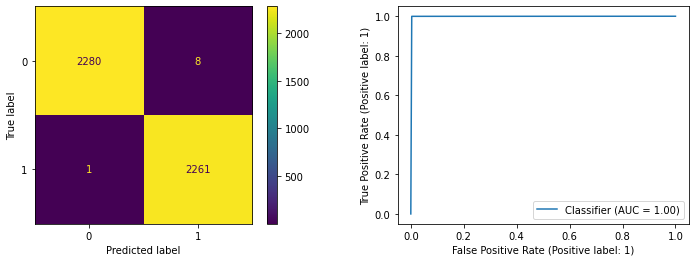

In [23]:
v1 = Voting([dt, knn], mode='soft', pretrained=True)
v1.fit(train_data, train_labels)
scores(v1, test_data, test_labels, 'two_best_soft.pdf')

Accuracy: 0.9716483516483516
Precision: 0.9907961343764381
Recall: 0.9518125552608311


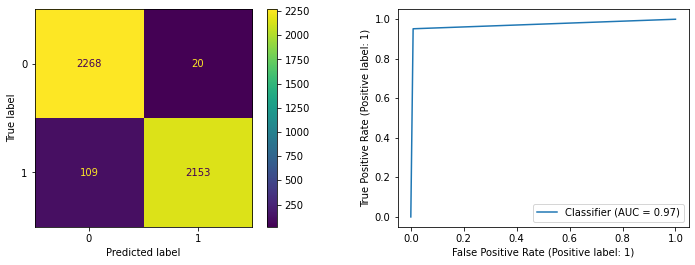

In [35]:
v2 = Voting([nb, svm, dt, knn, log], mode='soft', pretrained=True)
v2.fit(train_data, train_labels)
scores(v2, test_data, test_labels, 'all_soft.pdf')

Accuracy: 0.9624175824175825
Precision: 0.9865053513261982
Recall: 0.9372236958443855


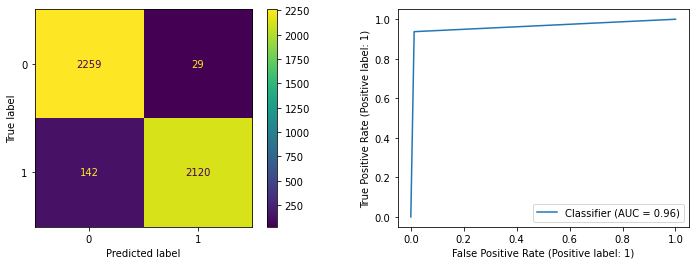

In [36]:
v3 = Voting([nb, svm, dt, knn, log], mode='hard', pretrained=True)
v3.fit(train_data, train_labels)
scores(v3, test_data, test_labels, 'all_hard.pdf')

## Случайный лес

In [10]:
class RandomForest(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, min_leaf_size=5, max_depth=None, criterion=entropy, max_features='sqrt', max_samples=0.8):
        self.n_estimators = n_estimators
        self.min_leaf_size = min_leaf_size
        self.max_depth = max_depth
        self.criterion = criterion
        self.max_features = max_features
        self.max_samples = max_samples
        
    def fit(self, data, labels):
        features = np.arange(data.shape[1])
        indexes = np.arange(len(data))
        samples = math.floor(self.max_samples * len(data))
        if self.max_features == 'sqrt':
            max_features = math.floor(np.sqrt(len(features)))
        else:
            max_features = math.floor(len(features) * self.max_features)
        self.estimators = []
        for _ in range(self.n_estimators):
            np.random.shuffle(features)
            self.estimators.append(DecisionTree(min_leaf_size=self.min_leaf_size, max_depth=self.max_depth, criterion=self.criterion, features=features[:max_features]))
            idx = np.random.choice(indexes, (samples, ))
            self.estimators[-1].fit(data[idx], labels[idx])
        
    def predict_proba(self, data):
        pred = np.stack([est.predict_proba(data) for est in self.estimators], axis=1)
        return pred.mean(axis=1)
    
    def predict(self, data):
        return self.predict_proba(data).argmax(axis=1)

In [12]:
rf_cv = GridSearchCV(RandomForest(),
                     {'max_samples': [0.8, 1], 'n_estimators': [20, 30, 40]})
rf_cv.fit(train_data, train_labels)
print(rf_cv.best_params_, rf_cv.best_score_, sep='\n')

{'max_samples': 1, 'n_estimators': 30}
0.9946153846153847


Accuracy: 0.9973626373626374
Precision: 0.9947229551451188
Recall: 1.0


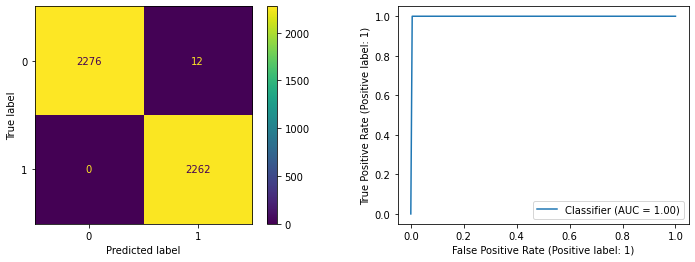

In [13]:
rf = rf_cv.best_estimator_
scores(rf, test_data, test_labels, 'random_forest.pdf')

## Градиентый бустинг

In [26]:
gb_cv = GridSearchCV(GradientBoostingClassifier(),
                    {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [10, 50, 100, 200]})
gb_cv.fit(train_data, train_labels)
print(gb_cv.best_params_, gb_cv.best_score_, sep='\n')

{'learning_rate': 0.5, 'n_estimators': 200}
0.9925824175824175


Accuracy: 0.9958241758241758
Precision: 0.9916703200350724
Recall: 1.0


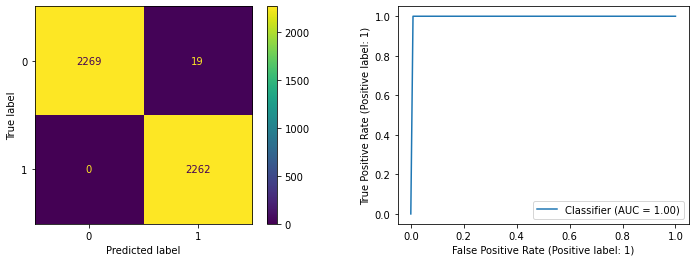

In [27]:
gb = gb_cv.best_estimator_
scores(gb, test_data, test_labels, 'grad_boost.pdf')

In [28]:
cb_cv = GridSearchCV(CatBoostClassifier(verbose=False), 
                     {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [10, 50, 100, 200]})
cb_cv.fit(train_data, train_labels, verbose=False)
print(cb_cv.best_params_, gb_cv.best_score_, sep='\n')

{'learning_rate': 0.5, 'n_estimators': 200}
0.9925824175824175


Accuracy: 0.9945054945054945
Precision: 0.9890686488850022
Recall: 1.0


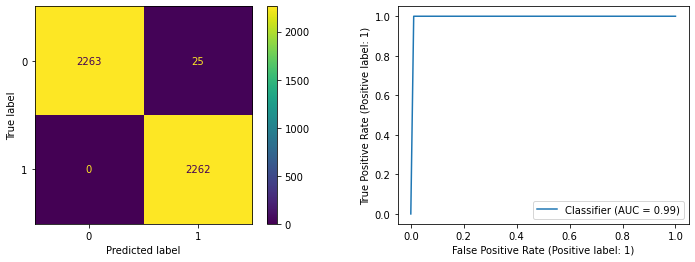

In [29]:
cb = cb_cv.best_estimator_
scores(cb, test_data, test_labels, 'cat_boost.pdf')